In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import skimage.io as skio
from skimage.color import rgb2gray, rgba2rgb, hsv2rgb
from skimage.transform import resize
import cv2

from tqdm.notebook import tqdm
import gdown
from glob import glob

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from fastcluster import linkage

In [2]:
def axis_mask(val, base):
    """
    Construct sliding kernel for centers based on cube dimension i.e base
    """
    if val == 0:
        inf_mask = 0
        sup_mask = base
    elif val == base:
        inf_mask = 0
        sup_mask = base
    elif val % base == 0:
        inf_mask = val - base
        sup_mask = val
    else:
        inf_mask = base * np.floor(val/base) # closest mulitple of
        sup_mask = base * np.ceil(val/base)
    return((int(inf_mask), int(sup_mask)))


def get_bounding_cubes(data, step = 3):
    """
    Get centers using mask
    """
    data_masks = []
    mask_center = []
    for pos, row in tqdm(enumerate(data), total=len(data)):
        x_mask = axis_mask(val=row[0], base=step )
        y_mask = axis_mask(val=row[1], base=step )
        z_mask = axis_mask(val=row[2], base=step)
        center_x = np.median(range(x_mask[0], x_mask[1] + 1))
        center_y = np.median(range(y_mask[0], y_mask[1] + 1))
        center_z = np.median(range(z_mask[0], z_mask[1] + 1))
        data_masks.append((x_mask,y_mask, z_mask))
        mask_center.append((int(center_x), int(center_y), int(center_z)))

    return(data, data_masks, mask_center)

def make_center_df(df, cols=[], cube_width = 3, return_result=True):
  """
  Return dataframe of image representing the RGB of reduced dimension (i.e using centers)
  """
  if not isinstance(cols, list):
    raise Exception("cols must be a list of columns from the dataframe")
  if len(cols) < 1:
    cols = df.columns
    df_ = df.copy()
  else:
    df_ = df.copy()
    df_ = df_[cols]


  boxes = get_bounding_cubes(df_.values, step = cube_width)
  center_df = pd.DataFrame(boxes[2])
  center_df.columns = [col + ' center' for col in df_.columns]
  res = pd.concat([df, center_df], axis=1)

  if return_result:
    return(res)

In [3]:
import scipy.cluster.hierarchy as sch
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

def rgb2hex(rgb):
    """
    Convert RGB to hexadecimal
    """
    try:
        r, g, b = tuple(rgb)
        return "#{:02x}{:02x}{:02x}".format(int(r),int(g),int(b))
    except:
        print(f'failed rgb {rgb}')

def make_plot_dendrogram(df, rgb_cols,  cluster_col, cluster_color_col, link, order_cluster=True):
    df_ = df.copy()
    clustered_leaf_labels = df_[cluster_color_col].values
    unclustered_leaf_labels = list(map(rgb2hex, df_[rgb_cols].values))

    plt.clf()
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link )
    leaf_order = dn['leaves']

    plt.rcParams.update({"font.size":16})
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["font.weight"] = "bold"
    ax = plt.gca()

    x_points = ax.get_xticks()
    y_points = np.zeros(len(x_points))
    xlbls = ax.get_xmajorticklabels()
    # print(ax.get_position())
    color_idx = []
    clustered_colors_list = []
    unclustered_colors_list = []

    # retrieve clustered colors and unclustered colors
    for lbl in xlbls:
        color_idx.append(int(lbl.get_text()))
        clustered_colors_list.append(clustered_leaf_labels[int(lbl.get_text())])
        unclustered_colors_list.append(unclustered_leaf_labels[int(lbl.get_text())])
        
    # get axis position [x0,y0,width,height]
    ax_bbox = ax.get_position()
    cax1 = fig.add_axes([ax_bbox.x0, 0.01, ax_bbox.width, 0.05])

    # create custom colorbar
    cm1 = LinearSegmentedColormap.from_list('custom_colormap', clustered_colors_list, N=len(clustered_colors_list))
    sc1 = plt.scatter(x_points, y_points, c=color_idx, cmap=cm1)
    clustered_cb = plt.colorbar(sc1, cax=cax1,  orientation='horizontal')

    # set the size of nex axis [x0,y0,width,height]
    cax2 = fig.add_axes([ax_bbox.x0, 0.065, ax_bbox.width, 0.05])
    cm2 = LinearSegmentedColormap.from_list('custom_colormap', unclustered_colors_list, N=len(unclustered_colors_list))
    sc2 = plt.scatter(x_points, y_points, c=color_idx, cmap=cm2)
    unclustered_cb = plt.colorbar(sc2, cax=cax2,  orientation='horizontal', pad = 0.3, ticks=np.linspace(0,19,20))
    
    if order_cluster:
    
        leaf_clusters = df_.iloc[leaf_order][cluster_col].drop_duplicates().values
        print(f'Ordering of leaf_clusters: {leaf_clusters}')
    
        # Create a mapping from original cluster IDs to new ordered IDs
        mapping_dict = {original: new for new, original in enumerate(leaf_clusters)}
        
        # Apply the mapping to create a new cluster label
        new_cluster_col = f'New_{cluster_col.lower()}'
        df_[new_cluster_col] = df_[cluster_col].map(mapping_dict)
        cluster_col = new_cluster_col    
    
    df_cluster_unique = df_[[cluster_col, cluster_color_col]].drop_duplicates().sort_values(cluster_col)
    
    cluster_colors = df_cluster_unique[cluster_color_col].values
    cluster_label = df_cluster_unique[cluster_col].values

    cax3 = fig.add_axes([ax_bbox.width+0.15, ax_bbox.y0, 0.05, ax_bbox.height-0.05])
    cmap = mpl.colors.ListedColormap(cluster_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,df_cluster_unique.shape[0]), cmap.N)
    sc3 = plt.scatter(cluster_label, np.zeros(len(cluster_label)), c = cluster_label, cmap=cmap, norm=norm)
    clustered_vert = plt.colorbar(sc3, cax=cax3,  orientation='vertical', spacing='proportional', ticks=np.linspace(0,19,20))
    # unclustered_cb.set_label('cluster id', loc='center', rotation=270, labelpad=30)
    clustered_vert.ax.set_title('Cluster Id', loc='center', pad=10, fontsize=16, fontweight='bold')

    # remove ticks and labels
    ax.set_xticklabels([])

    # clustered_cb.ax.set_ylabel(ylabel='Clustered', rotation=270, loc='center', fontsize=20, labelpad=25)
    # unclustered_cb.ax.set_ylabel(ylabel='Unclustered', rotation=270, loc='center', fontsize=20, labelpad=25)
    clustered_cb.ax.tick_params(size=0)
    unclustered_cb.ax.tick_params(size=0)
    clustered_cb.ax.set_xticklabels([])
    unclustered_cb.ax.set_xticklabels([])
        # Save the plot as a PDF before showing it
    plt.savefig('Standard_HC_Tree.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
        # Your existing plot code here
    return mapping_dict


import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

def representative_rgb(df, cols, method="mean", weights=None, qtl=None):
    df_ = df.copy()
    df_ = df_[cols]
    if method == "mean":
        return tuple(df_.mean().astype(int))
    
    elif method == "quantile":
        if qtl is None:
            raise ValueError("A quantile value is required for the quantile method.\n\nExample: Pass qtl=0.5 for the median.")
        return tuple(df_.quantile(qtl).astype(int))
    
    elif method == "mode":
        mode_val = df_.mode().iloc[0]
        return tuple(mode_val.astype(int))
    
    elif method == "dominant":
        kmeans = KMeans(n_clusters=1).fit(df_)
        dominant_color = kmeans.cluster_centers_[0]
        return tuple(dominant_color.astype(int))
    
    elif method == "weighted":
        if weights is None:
            raise ValueError("Weights are required for the weighted average method.")
        weighted_avg = (df_.T * weights).T.sum() / sum(weights)
        return tuple(weighted_avg.astype(int))
    
    elif method == "pca":
        if (df_.var() == 0).any():
            print("Warning: One or more columns have zero variance. PCA will not work with these columns.\n\nReturning the mean instead.")
            return tuple(df_.mean().astype(int))
        pca = PCA(n_components=1)
        transformed_data = pca.fit_transform(df_)
        representative_score = np.mean(transformed_data, axis=0)
        pca_color = pca.inverse_transform(representative_score)
        return tuple(pca_color.astype(int))

    
    elif method == "harmonic":
        harmonic_mean = df_.apply(stats.hmean, axis=0) if not df_.isin([0]).any().any() else df_.mean()
        return tuple(harmonic_mean.astype(int))
    
    else:
        raise ValueError(f"Unknown method: {method}")



def ColorsSequence3DScatterPerCluster(df, cols, method, weights=None, qtl=None):
    df_ = df.copy()
    clusters = df_['Clusters'].drop_duplicates()
    for ii in range(clusters.shape[0]):
        colors = df_.query('Clusters == {}'.format(ii))
        color_rep = representative_rgb(colors, cols, method=method, weights=weights, qtl=qtl)[:3]
        df_.loc[df_['Clusters'] == ii, 'ClusterColor'] = rgb2hex(color_rep)

    return df_

def mapClusters(df, link, n_clusters = 2, height = None):
    df_ = df.copy()
    if height == None:
        clusters = sch.cut_tree(Z=link, n_clusters=n_clusters)
    else:
        clusters = sch.cut_tree(Z=link, height = height)
    df_['Clusters'] = clusters
    return df_

def cluster_center(df, center_cols, n_cluster,  method,
                   weights=None, qtl=None, plot_dendrogram = True):
    df_ = df.copy()
    df_center_unique = df_[center_cols].drop_duplicates()
    link = sch.linkage(df_center_unique, method='ward')
    df_center_unique = ColorsSequence3DScatterPerCluster(mapClusters(df_center_unique, link, n_cluster), center_cols,  method, weights, qtl)
    df__ = pd.merge(df_, df_center_unique, how='right', on=center_cols).drop_duplicates(subset=center_cols)
    df_ = pd.merge(df_, df_center_unique, how='left', on=center_cols)

    if plot_dendrogram:
        mapping_dict = make_plot_dendrogram(df=df__, rgb_cols=center_cols, cluster_col='Clusters',cluster_color_col='ClusterColor', link=link)
        df_['Clusters'] = df_['Clusters'].map(mapping_dict)
    return(df_)


In [7]:
melon_standard_df = pd.read_csv('./melon_standard/combined_pixel_data.csv')
melon_standard_df.dropna(subset=['filename'], inplace=True)
melon_standard_df.reset_index(drop=True, inplace=True)
melon_standard_df

,Row,Col,Red,Green,Blue,Tip,filename,filepath
0,0,988,214,203,181,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...
1,0,989,212,202,177,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...
2,0,990,209,199,174,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...
3,0,991,209,199,172,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...
4,0,992,211,201,174,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...
...,...,...,...,...,...,...,...,...
22536148,2394,1188,215,200,171,NaN,A25_T1_nd_8dsl_week2,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...
22536149,2394,1189,217,202,173,NaN,A25_T1_nd_8dsl_week2,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...
22536150,2394,1190,214,200,173,NaN,A25_T1_nd_8dsl_week2,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...
22536151,2394,1191,216,202,175,NaN,A25_T1_nd_8dsl_week2,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...


In [ ]:
melon_standard_df = make_center_df(melon_standard_df, cols=['Red', 'Green', 'Blue'], cube_width=3)

  0%|          | 0/22536153 [00:00<?, ?it/s]

Ordering of leaf_clusters: [11  4  3 10  9  6  0  1  2  8  5  7]


<Figure size 640x480 with 0 Axes>

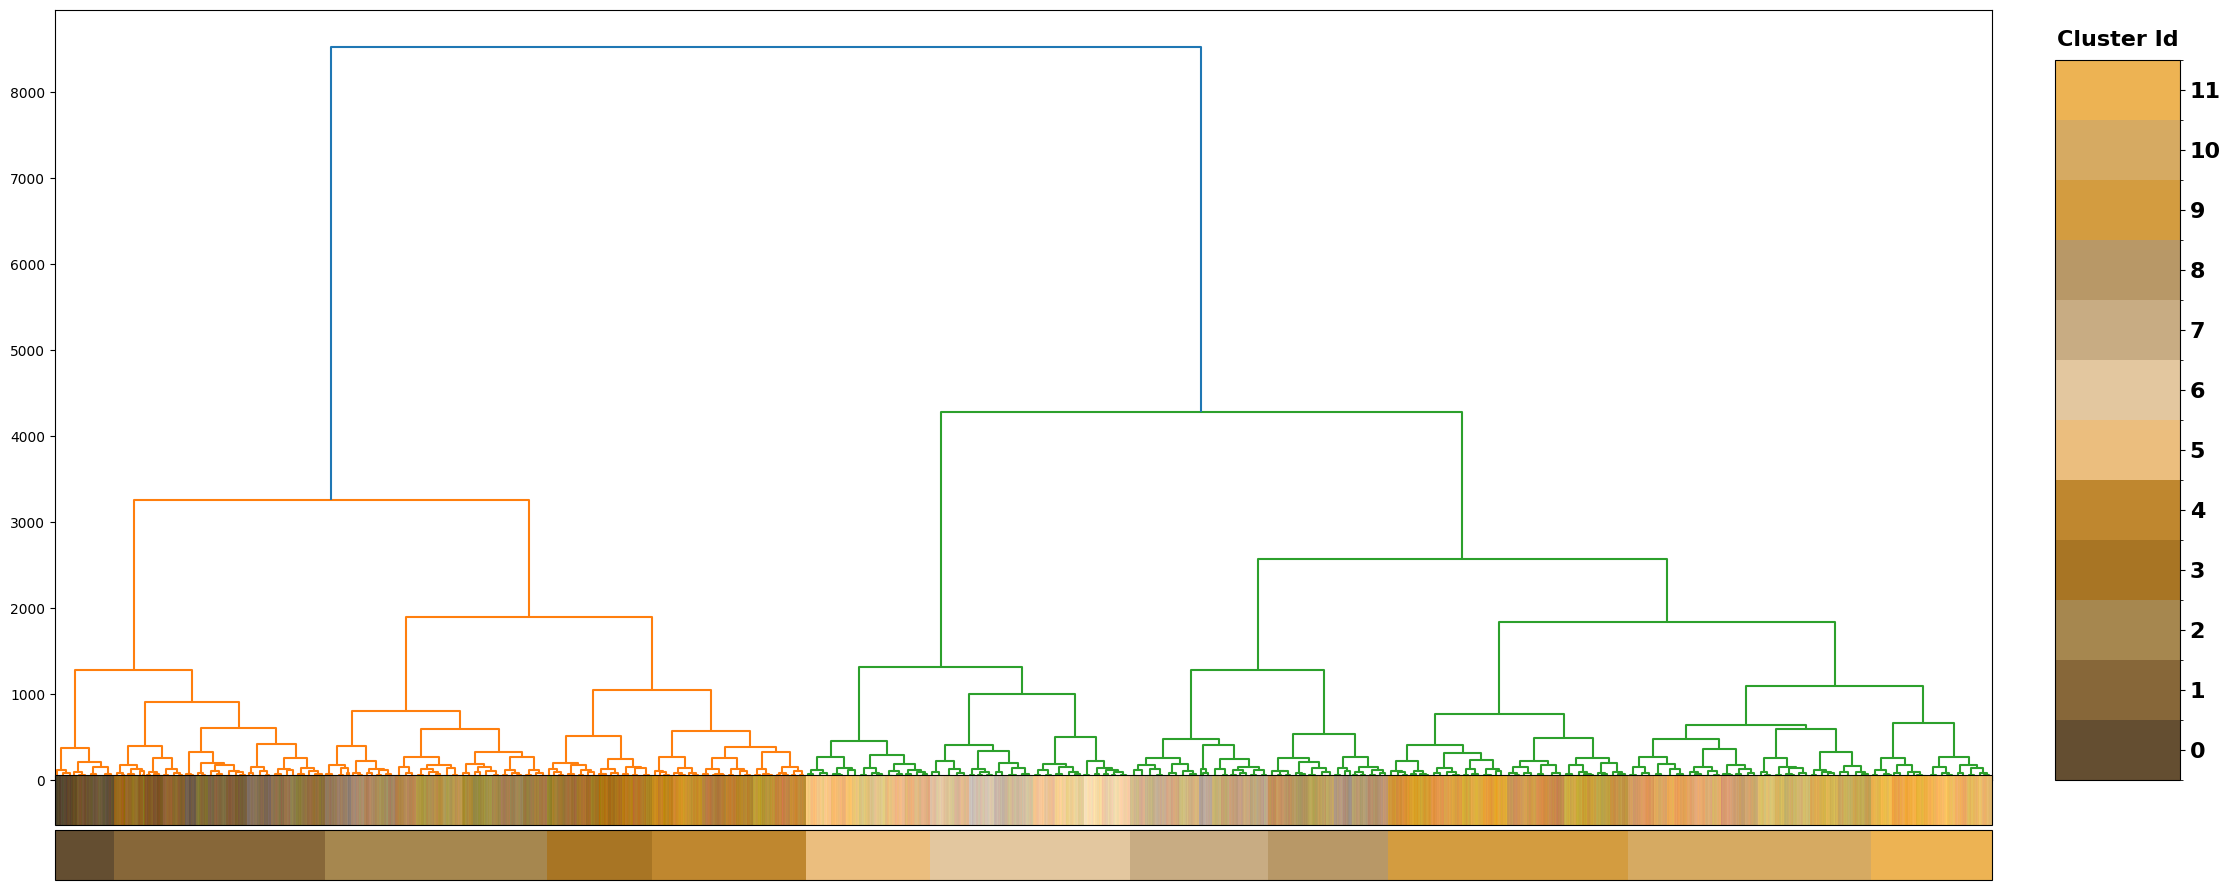

,Row,Col,Red,Green,Blue,Tip,filename,filepath,Red center,Green center,Blue center,Clusters,ClusterColor
0,0,988,214,203,181,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,214,202,181,6,#e3c79f
1,0,989,212,202,177,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,211,202,175,6,#e3c79f
2,0,990,209,199,174,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,208,199,172,6,#e3c79f
3,0,991,209,199,172,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,208,199,172,6,#e3c79f
4,0,992,211,201,174,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,211,199,172,6,#e3c79f
5,0,993,210,200,175,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,208,199,175,6,#e3c79f


In [9]:
melon_standard_df_ = cluster_center(df=melon_standard_df, center_cols=[f"{channel} center" for channel in ['Red', 'Green', 'Blue']], 
                                  n_cluster=12, method='pca', plot_dendrogram=True)


melon_standard_df_.head(6)

In [10]:

pd.DataFrame(melon_standard_df_[['Clusters', 'ClusterColor']].value_counts(normalize=True)).mul(100).round(3).sort_values(by=['Clusters'], ascending=True)

# pd.DataFrame(melon_standard_df.loc[melon_standard_df.filename == 'S1', ['Clusters', 'ClusterColor']].value_counts(normalize=True)).mul(100).round(2).sort_values(by=['Clusters'], ascending=True)

,,proportion
Clusters,ClusterColor,
0,#644e31,0.008
1,#876739,0.064
2,#a6874f,0.458
3,#a87524,0.039
4,#bf872f,0.206
5,#ebbe7e,31.038
6,#e3c79f,17.996
7,#c8ac83,14.641
8,#b89867,1.872


In [11]:
melon_standard_df__ = melon_standard_df_.drop_duplicates(subset=['Red center',	'Green center',	'Blue center'])
melon_standard_df__

,Row,Col,Red,Green,Blue,Tip,filename,filepath,Red center,Green center,Blue center,Clusters,ClusterColor
0,0,988,214,203,181,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,214,202,181,6,#e3c79f
1,0,989,212,202,177,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,211,202,175,6,#e3c79f
2,0,990,209,199,174,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,208,199,172,6,#e3c79f
4,0,992,211,201,174,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,211,199,172,6,#e3c79f
5,0,993,210,200,175,NaN,A01_T1_nd_0dsl_week1,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,208,199,175,6,#e3c79f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22246276,2113,469,171,137,63,NaN,A25_T1_nd_8dsl_week2,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,169,136,61,2,#a6874f
22247762,2114,471,174,138,60,NaN,A25_T1_nd_8dsl_week2,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,172,136,58,2,#a6874f
22422269,2246,543,219,201,181,NaN,A25_T1_nd_8dsl_week2,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,217,199,181,6,#e3c79f
22516126,2346,789,219,205,178,NaN,A25_T1_nd_8dsl_week2,/Users/bw/Documents/Melon/Trial-1-2023/Melon-A...,217,205,178,6,#e3c79f


In [12]:
melon_standard_df__.to_csv('./melon_standard/deduplicated_combined_pixel_data_clustered.csv', index=False)

In [13]:
pd.DataFrame(melon_standard_df__[['filename', 'Clusters', 'ClusterColor']].value_counts(normalize=True)).mul(100).round(2).sort_values(by=['filename', 'Clusters'], ascending=True)

proportion
filename             Clusters ClusterColor            
A01_T1_nd_0dsl_week1 1        #876739             0.59
                     2        #a6874f             4.41
                     3        #a87524             0.32
                     4        #bf872f             0.17
                     5        #ebbe7e             3.05
...                                                ...
C49_T1_nd_4dsl_week3 7        #c8ac83             1.16
                     8        #b89867             1.36
                     9        #d39c40             5.66
                     10       #d6aa62             2.29
                     11       #edb353             3.41

[67 rows x 1 columns]

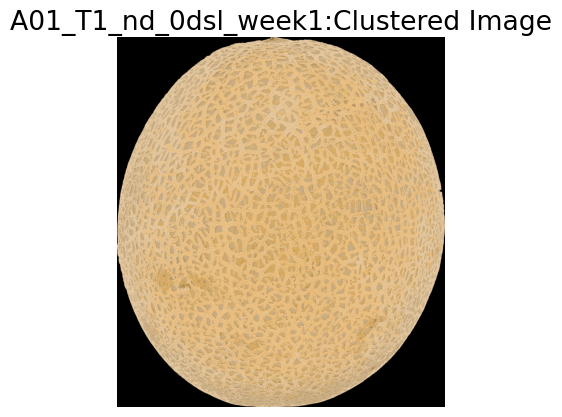

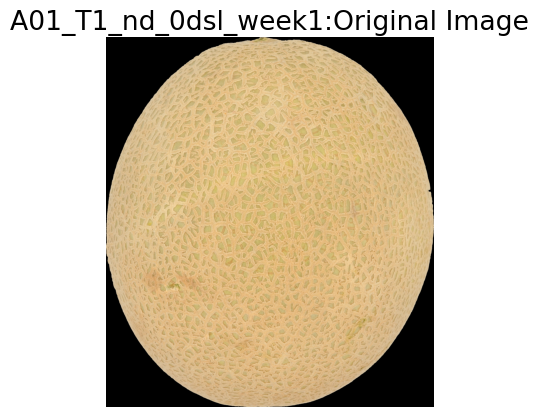

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import numpy as np
import cv2
# draw melon_stadnard_df_ image using Row, Col, Red, Green, Blue columns
def plot_image(df, title, cluster = False):
    # 이미지 크기 계산 (Row와 Col의 최대값 찾기)
    max_row = df["Row"].max() + 1
    max_col = df["Col"].max() + 1

    # 빈 이미지 배열 생성 (H, W, 3) - 3채널(RGB)
    image = np.zeros((max_row, max_col, 3), dtype=np.uint8)

    # 각 픽셀에 RGB 값 적용
    for _, row in df.iterrows():
        r, c = row["Row"], row["Col"]
        if cluster:
            image[r, c] = np.array(mcolors.hex2color(row["ClusterColor"])) * 255
        else:
            image[r, c] = [row["Red"], row["Green"], row["Blue"]]

    # 이미지 출력
    plt.imshow(image)
    plt.axis("off")  # 축 숨기기
    plt.title(title)
    plt.show()

plot_image(melon_standard_df_.loc[melon_standard_df_.filename == "A01_T1_nd_0dsl_week1"], "A01_T1_nd_0dsl_week1:Clustered Image", True)
plot_image(melon_standard_df_.loc[melon_standard_df_.filename == "A01_T1_nd_0dsl_week1"], "A01_T1_nd_0dsl_week1:Original Image")

In [55]:
cluster_list = melon_standard_df_[["Clusters", "ClusterColor"]].drop_duplicates(subset=["ClusterColor"])
color_cluster = np.zeros(12, dtype=object)

for row in cluster_list.itertuples():
    color_cluster[row.Clusters] = row.ClusterColor

np.save('./result/color_cluster.npy', color_cluster)
color_cluster

array(['#644e31', '#876739', '#a6874f', '#a87524', '#bf872f', '#ebbe7e',
       '#e3c79f', '#c8ac83', '#b89867', '#d39c40', '#d6aa62', '#edb353'],
      dtype=object)

In [ ]:
def find_nearest_cluster(image, cluster_list):
    # finding nearest cluster for each pixel of given image

    # Create a 2D array of pixel colors
    pixel_colors = image.reshape(-1, 3)

    # Create a 2D array of cluster colors
    cluster_colors = np.array([mcolors.hex2color(color) for color in cluster_list]) * 255

    # Calculate the Euclidean distance between each pixel and each cluster
    distances = np.linalg.norm(pixel_colors[:, None] - cluster_colors, axis=2)

    # Find the nearest cluster for each pixel
    nearest_clusters = np.argmin(distances, axis=1)

    return nearest_clusters

# Load an image
image = cv2.imread('/Users/bw/Documents/Melon/Trial-1-2023/Melon-A-0dsl-week1/A01_T1_nd_0dsl_week1.jpg')
tmp = find_nearest_cluster(image, color_cluster)


In [53]:
# see tmp frequency table
pd.Series(tmp).value_counts(normalize=True).mul(100).round(2).sort_values(ascending=True)

1     0.08
2     0.09
8     0.25
0     0.88
7    14.07
6    84.62
Name: proportion, dtype: float64